Para hacer apply a un daskdataframe es necesario pasarle meta que es el tipo de datos que va a tener. https://stackoverflow.com/a/44437675

In [2]:
import pandas as pd
import numpy as np
import glob
import os
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
# import dask.dataframe as dd # en caso de tener muchos datos
import locale
import re
locale.setlocale(locale.LC_TIME, "es_ES") 

'es_ES'

In [3]:
os.listdir()

['.git',
 '.gitignore',
 '2022_emt_evolucion.ipynb',
 'datos',
 'gfts.ipynb',
 'images',
 'pasajeros.ipynb',
 'README.md']

In [7]:
files = glob.glob("datos/Coches_Cuadro_Oferta_Real/*/Coches_Cuadro_Oferta_Real_*.csv")
# print(files)
# files = glob.glob("*/*Enero-Junio_*.csv")
files

['datos/Coches_Cuadro_Oferta_Real\\Coches_Cuadro_Oferta_Real_2019\\Coches_Cuadro_Oferta_Real_Enero-Junio_2019.csv',
 'datos/Coches_Cuadro_Oferta_Real\\Coches_Cuadro_Oferta_Real_2019\\Coches_Cuadro_Oferta_Real_Julio-Diciembre_2019.csv',
 'datos/Coches_Cuadro_Oferta_Real\\Coches_Cuadro_Oferta_Real_2020\\Coches_Cuadro_Oferta_Real_Enero-Junio_2020.csv',
 'datos/Coches_Cuadro_Oferta_Real\\Coches_Cuadro_Oferta_Real_2020\\Coches_Cuadro_Oferta_Real_Julio-Diciembre_2020.csv',
 'datos/Coches_Cuadro_Oferta_Real\\Coches_Cuadro_Oferta_Real_2021\\Coches_Cuadro_Oferta_Real_Enero-Junio_2021.csv',
 'datos/Coches_Cuadro_Oferta_Real\\Coches_Cuadro_Oferta_Real_2021\\Coches_Cuadro_Oferta_Real_Julio-Diciembre_2021.csv']

In [8]:
# Read column names from file
cols = list(pd.read_csv(files[0], sep=';',nrows=1))
cols = list(filter(lambda col: col.strip(), cols))


#Cargamos los datos y especificamos los tipos en las columnas, así como eliminar la última columna por ser vacia
dfs = [pd.read_csv(f, header=0, sep=";",encoding = "ISO-8859-1",dtype={'Elinea':'str'},usecols=cols) for f in files]
df = pd.concat(dfs,ignore_index=True)


# Elimnar el último dataframe del último fichero de la memoria
del dfs

In [9]:
df.to_csv('datos/Coches_Cuadro_Oferta_Real/autobuses_oferta_real.csv')

In [ ]:
df.FServicio = pd.to_datetime(df.FServicio, format='%d/%m/%Y')

tiempos = pd.DataFrame({'FServicio': pd.date_range('2019-01-01', '2021-12-31', freq='D')})
tiempos['fechaCorta'] = tiempos['FServicio'].dt.strftime('%B.%Y')
tiempos

,FServicio,fechaCorta
0,2019-01-01,enero.2019
1,2019-01-02,enero.2019
2,2019-01-03,enero.2019
3,2019-01-04,enero.2019
4,2019-01-05,enero.2019
...,...,...
1091,2021-12-27,diciembre.2021
1092,2021-12-28,diciembre.2021
1093,2021-12-29,diciembre.2021
1094,2021-12-30,diciembre.2021


In [ ]:
df = df.join(tiempos.set_index('FServicio'),on='FServicio')

In [ ]:
# cabeceras = df.loc[:,['CLinea','Elinea','Denominacion']].drop_duplicates().reset_index(drop=True)
# cabeceras[cabeceras['Elinea']!='SE']
# df.sort_values(by=['CLinea','FServicio','IDFranja'])
# df['year'] = df['FServicio'].dt.year
# df['month'] = df['FServicio'].dt.month

In [ ]:
# Completamos con 0 las franjas horarias que esten a nulo.
df['Coches'] = df['Coches'].fillna(0)

# Añadimos si ese día era L-V o S-D
df['Diario'] = True
df.loc[df['FServicio'].dt.dayofweek > 4,'Diario'] = False

In [ ]:
df['avg_coches'] = df.groupby(by=['CLinea', 'fechaCorta', 'IDFranja']).Coches.transform('mean')
# https://stackoverflow.com/questions/38869778/pandas-set-column-equal-to-grouped-sum-of-another-column?noredirect=1&lq=1


In [ ]:
df[\
    (df['IDFranja']=='H07')\
    &(df['CLinea']==1)\
    &(df['FServicio'].dt.year==2019)\
    &(df['FServicio'].dt.month==1)\
    ].head()

,CLinea,Elinea,Denominacion,FServicio,IDFranja,Intervalo,Coches,fechaCorta,Diario,avg_coches
0,1,1,PLAZA DE CRISTO REY - PROSPERIDAD,2019-01-01,H07,070000 - 075959,2.0,enero.2019,True,5.580645
19,1,1,PLAZA DE CRISTO REY - PROSPERIDAD,2019-01-02,H07,070000 - 075959,6.0,enero.2019,True,5.580645
38,1,1,PLAZA DE CRISTO REY - PROSPERIDAD,2019-01-03,H07,070000 - 075959,6.0,enero.2019,True,5.580645
57,1,1,PLAZA DE CRISTO REY - PROSPERIDAD,2019-01-04,H07,070000 - 075959,6.0,enero.2019,True,5.580645
76,1,1,PLAZA DE CRISTO REY - PROSPERIDAD,2019-01-05,H07,070000 - 075959,3.0,enero.2019,False,5.580645


In [ ]:
# De esta forma pierdo las columnas de 'Denominación' etc. 
# medias_buses = df.groupby(['CLinea','year','month','IDFranja'],as_index=False).mean() 

# En cambio eliminando los duplicados fijándonos por CLinea, FechaCorta e ID Franja mantenemos todas las columnas.
media_buses = df.drop_duplicates(['CLinea','fechaCorta','IDFranja','avg_coches'])

In [ ]:
media_buses[(media_buses['IDFranja']=='H07')&(media_buses['CLinea']==25)].head()

,CLinea,Elinea,Denominacion,FServicio,IDFranja,Intervalo,Coches,fechaCorta,Diario,avg_coches
79249,25,25,PLAZA DE ESPAÑA - CASA DE CAMPO,2019-01-01,H07,070000 - 075959,3.0,enero.2019,True,10.709677
79859,25,25,PLAZA DE ESPAÑA - CASA DE CAMPO,2019-02-01,H07,070000 - 075959,14.0,febrero.2019,True,11.071429
80410,25,25,PLAZA DE ESPAÑA - CASA DE CAMPO,2019-03-01,H07,070000 - 075959,14.0,marzo.2019,True,11.000000
81020,25,25,PLAZA DE ESPAÑA - CASA DE CAMPO,2019-04-01,H07,070000 - 075959,15.0,abril.2019,True,10.933333
81606,25,25,PLAZA DE ESPAÑA - CASA DE CAMPO,2019-05-01,H07,070000 - 075959,4.0,mayo.2019,True,10.838710


In [ ]:
def graficar(num_linea,franja,guardar=False):
    fig, axes = plt.subplots(figsize=(12, 5),dpi=100)
    axes.spines.right.set_visible(False)
    axes.spines.top.set_visible(False)

    # num_linea = 21
    # franja = 'H10'

    # Filtro por linea y franja
    data = media_buses[(media_buses['IDFranja']==franja)&(media_buses['CLinea']==num_linea)].reset_index(drop=True)
    if len(data)==0:
        listado_franjas = media_buses.loc[media_buses['CLinea']==num_linea,'IDFranja'].unique()
        raise Exception(f"Las franjas horarias de la linea {num_linea} son: {listado_franjas}") 
    lineaPublico = str(data.loc[0,"Elinea"])
    cartel_linea = str(data.loc[0,"Denominacion"])

    # Visualizo los datos (avg_coches) y fechas
    for fecha in data['FServicio'].dt.year.unique():
        # df.loc[df.index >= N, 'GDP'].plot(color='r', ax=ax)
        axes.plot(data.loc[data['FServicio'].dt.year == fecha,'fechaCorta'],data.loc[data['FServicio'].dt.year == fecha,'avg_coches'],'-o',label='Franja: '+ franja +'\nAño: '+str(fecha))


    # Configuraciones visuales
    axes.set_xticks(data['fechaCorta'])
    axes.set_xticklabels(data['fechaCorta'], rotation = 45, ha="right",fontdict=dict({'color': 'grey'}))
    axes.set_ylim([0,data['Coches'].max()+3])

    xTicks = axes.get_xticklabels()
    indices_enero = [i for i, item in enumerate(data.fechaCorta) if re.search('enero', item)]
    for indeceEnero in indices_enero:
        xTicks[indeceEnero].set_color('black')
        # axes.vlines(x=indeceEnero,ymin=0,ymax=axes.get_yticks().max(),colors='black',linestyles='dashed',)

    # Título y nombre ejes
    axes.set_xlabel('fecha')
    axes.set_ylabel('Media_NumeroDeBus')
    axes.set_title(label=f'Evolución núm. autobuses (media)\nLÍNEA {lineaPublico}: {cartel_linea}',pad=20)
    # axes.set(
    #     xlabel='Mes',
    #     ylabel='Media_NumeroDeBus',
    #     title=f'Evolución núm. autobuses (media)\nLÍNEA {num_linea}: {cartel_linea}'
    #     )
    axes.grid(color="#172a3d", linestyle='--', linewidth=1, axis='both', alpha=0.15)
    leg= axes.legend(bbox_to_anchor=(1.025, 1), loc=2, borderaxespad=0)


    plt.draw()

    # FALTA POR HACER ESTO-> Poner una caja debajo de las leyedenas que muestren datos como máx y min
    # p = leg.get_window_extent()
    # print(p)
    # axes.annotate('Annotation Text', (p.p0[0], p.p1[1]+10), (p.p0[0], p.p1[1]), 
    #             xycoords='figure pixels', zorder=9)


    # plt.legend(loc="lower right") # Esto puede deshabilitar quitando la línea
    if guardar:
        plt.savefig(fname=f'images/LÍNEA_{num_linea}_{franja}_{cartel_linea}.jpg',format='jpg', bbox_inches='tight', dpi=200)

    plt.show()

# Pendiente de hacer
Calcular para cada linea y franja horaria la diferencia de autobuses por mes para cada año 

| Línea |   Fecha    | Diff.AñoAnterior |
|-------|   -------  |------------------|
|   1   | enero.2020 |       10%        |
|   1   | enero.2021 |       -5%        |


#### Duda
Si quisiera mirar la línea que mayor diferencia ha tenido (sin tener en consideración la pandemia) me saldría ordenado por franjas horarias, pero no por linea y franja.

In [ ]:
linea25 = media_buses[media_buses['CLinea']==25]

In [ ]:
linea25 = linea25[linea25['FServicio'].dt.day==1]
linea25

,CLinea,Elinea,Denominacion,FServicio,IDFranja,Intervalo,Coches,fechaCorta,Diario,avg_coches
79249,25,25,PLAZA DE ESPAÑA - CASA DE CAMPO,2019-01-01,H07,070000 - 075959,3.0,enero.2019,True,10.709677
79250,25,25,PLAZA DE ESPAÑA - CASA DE CAMPO,2019-01-01,H08,080000 - 085959,3.0,enero.2019,True,12.838710
79251,25,25,PLAZA DE ESPAÑA - CASA DE CAMPO,2019-01-01,H09,090000 - 095959,4.0,enero.2019,True,13.451613
79252,25,25,PLAZA DE ESPAÑA - CASA DE CAMPO,2019-01-01,H10,100000 - 105959,4.0,enero.2019,True,13.064516
79253,25,25,PLAZA DE ESPAÑA - CASA DE CAMPO,2019-01-01,H11,110000 - 115959,4.0,enero.2019,True,10.548387
...,...,...,...,...,...,...,...,...,...,...
3280658,25,25,PLAZA DE ESPAÑA - CASA DE CAMPO,2021-12-01,H20,200000 - 205959,12.0,diciembre.2021,True,9.645161
3280659,25,25,PLAZA DE ESPAÑA - CASA DE CAMPO,2021-12-01,H21,210000 - 215959,9.0,diciembre.2021,True,7.967742
3280660,25,25,PLAZA DE ESPAÑA - CASA DE CAMPO,2021-12-01,H22,220000 - 225959,7.0,diciembre.2021,True,6.633333
3280661,25,25,PLAZA DE ESPAÑA - CASA DE CAMPO,2021-12-01,H23,230000 - 235959,6.0,diciembre.2021,True,5.758621


In [ ]:
# media_buses.apply(lambda x: calcularDiferencia(x))

######################
# PENDIENTE DE HACER #
######################

# lineas = media_buses['CLinea'].unique()

# for linea in lineas:
#     linea_df = media_buses[media_buses['CLinea']==linea]
#     anios_linea = linea_df['FServicio'].dt.year
#     anios_linea = anios_linea.unique()
#     franjas_linea = sorted(linea_df['IDFranja'].unique())
#     print(anios_linea,franjas_linea,linea)

In [ ]:
tmp = media_buses.copy()

In [ ]:
tmp['mes'] = tmp['FServicio'].dt.month
tmp['year'] = tmp['FServicio'].dt.year

In [ ]:
tmp['key_1'] = tmp['CLinea'].astype(str).str.zfill(3)+tmp['IDFranja']+tmp['mes'].astype(str)+tmp['year'].astype(str)
tmp['key_2'] = tmp['CLinea'].astype(str).str.zfill(3)+tmp['IDFranja']+tmp['mes'].astype(str)+(tmp['year']-1).astype(str)
tmp['key_3'] = tmp['CLinea'].astype(str).str.zfill(3)+tmp['IDFranja']+tmp['mes'].astype(str)+(tmp['year']-2).astype(str)


In [ ]:
tmp2 = tmp.loc[:,['key_1','key_2','key_3','FServicio','fechaCorta','CLinea','IDFranja','avg_coches']]

In [ ]:
tmp2

,key_1,key_2,FServicio,fechaCorta,CLinea,IDFranja,avg_coches
0,001H0712019,001H0712018,2019-01-01,enero.2019,1,H07,5.580645
1,001H0812019,001H0812018,2019-01-01,enero.2019,1,H08,6.580645
2,001H0912019,001H0912018,2019-01-01,enero.2019,1,H09,7.387097
3,001H1012019,001H1012018,2019-01-01,enero.2019,1,H10,8.903226
4,001H1112019,001H1112018,2019-01-01,enero.2019,1,H11,9.193548
...,...,...,...,...,...,...,...
3865871,781H2082021,781H2082020,2021-08-01,agosto.2021,781,H20,7.758621
3865872,781H2182021,781H2182020,2021-08-01,agosto.2021,781,H21,7.068966
3865873,781H2282021,781H2282020,2021-08-01,agosto.2021,781,H22,6.379310
3865874,781H2382021,781H2382020,2021-08-01,agosto.2021,781,H23,5.000000


In [ ]:
# https://stackoverflow.com/questions/41511730/python-function-similar-to-vlookup-excel
if 'avg_key_2' in tmp2.columns:
    tmp2.drop(columns=['avg_key_2'],inplace=True)
if 'avg_key_3' in tmp2.columns:
    tmp2.drop(columns=['avg_key_3'],inplace=True)

tmp2.insert(len(tmp2.columns), 'avg_key_2', tmp2['key_2'].map(tmp2.set_index('key_1')['avg_coches']))
tmp2.insert(len(tmp2.columns), 'avg_key_3', tmp2['key_3'].map(tmp2.set_index('key_1')['avg_coches']))
# tmp2.fillna(0,inplace=True)
tmp2.reset_index(inplace=True,drop=True)

tmp2

,key_1,key_2,FServicio,fechaCorta,CLinea,IDFranja,avg_coches,avg_ant
0,001H0712019,001H0712018,2019-01-01,enero.2019,1,H07,5.580645,NaN
1,001H0812019,001H0812018,2019-01-01,enero.2019,1,H08,6.580645,NaN
2,001H0912019,001H0912018,2019-01-01,enero.2019,1,H09,7.387097,NaN
3,001H1012019,001H1012018,2019-01-01,enero.2019,1,H10,8.903226,NaN
4,001H1112019,001H1112018,2019-01-01,enero.2019,1,H11,9.193548,NaN
...,...,...,...,...,...,...,...,...
136249,781H2082021,781H2082020,2021-08-01,agosto.2021,781,H20,7.758621,NaN
136250,781H2182021,781H2182020,2021-08-01,agosto.2021,781,H21,7.068966,NaN
136251,781H2282021,781H2282020,2021-08-01,agosto.2021,781,H22,6.379310,NaN
136252,781H2382021,781H2382020,2021-08-01,agosto.2021,781,H23,5.000000,NaN


In [ ]:
tmp2['diff_key1_key2'] = (tmp2['avg_coches']-tmp2['avg_key_2'])
tmp2['diff_key1_key3'] = (tmp2['avg_coches']-tmp2['avg_key_3'])

In [ ]:
tmp2.sort_values(by='diff_key1_key3')

,key_1,key_2,FServicio,fechaCorta,CLinea,IDFranja,avg_coches,avg_ant,diff
47234,019H0842020,019H0842019,2020-04-01,abril.2020,19,H08,10.833333,21.800000,-10.966667
47235,019H0942020,019H0942019,2020-04-01,abril.2020,19,H09,11.700000,22.600000,-10.900000
47236,019H1042020,019H1042019,2020-04-01,abril.2020,19,H10,8.400000,17.766667,-9.366667
48176,027H0842020,027H0842019,2020-04-01,abril.2020,27,H08,9.866667,19.133333,-9.266667
47242,019H1642020,019H1642019,2020-04-01,abril.2020,19,H16,6.733333,15.900000,-9.166667
...,...,...,...,...,...,...,...,...,...
136249,781H2082021,781H2082020,2021-08-01,agosto.2021,781,H20,7.758621,NaN,NaN
136250,781H2182021,781H2182020,2021-08-01,agosto.2021,781,H21,7.068966,NaN,NaN
136251,781H2282021,781H2282020,2021-08-01,agosto.2021,781,H22,6.379310,NaN,NaN
136252,781H2382021,781H2382020,2021-08-01,agosto.2021,781,H23,5.000000,NaN,NaN


In [ ]:
tmp3 = tmp2[tmp2['FServicio'].dt.year!=2020].sort_values(by='diff')
tmp3 = tmp3[tmp3['CLinea']<500]
tmp3['diff'].fillna(0,inplace=True)
tmp3

,key_1,key_2,FServicio,fechaCorta,CLinea,IDFranja,avg_coches,avg_ant,diff
92230,021H1022021,021H1022020,2021-02-01,febrero.2021,21,H10,15.035714,18.482759,-3.447044
90928,009H0812021,009H0812020,2021-01-01,enero.2021,9,H08,14.000000,16.903226,-2.903226
128791,148H21122021,148H21122020,2021-12-01,diciembre.2021,148,H21,6.870968,9.612903,-2.741935
92232,021H1222021,021H1222020,2021-02-01,febrero.2021,21,H12,17.035714,19.758621,-2.722906
90929,009H0912021,009H0912020,2021-01-01,enero.2021,9,H09,14.250000,16.967742,-2.717742
...,...,...,...,...,...,...,...,...,...
133065,405H19122021,405H19122020,2021-12-01,diciembre.2021,405,H19,3.580645,NaN,0.000000
133066,405H20122021,405H20122020,2021-12-01,diciembre.2021,405,H20,3.612903,NaN,0.000000
133067,405H21122021,405H21122020,2021-12-01,diciembre.2021,405,H21,3.580645,NaN,0.000000
133068,405H22122021,405H22122020,2021-12-01,diciembre.2021,405,H22,3.600000,NaN,0.000000


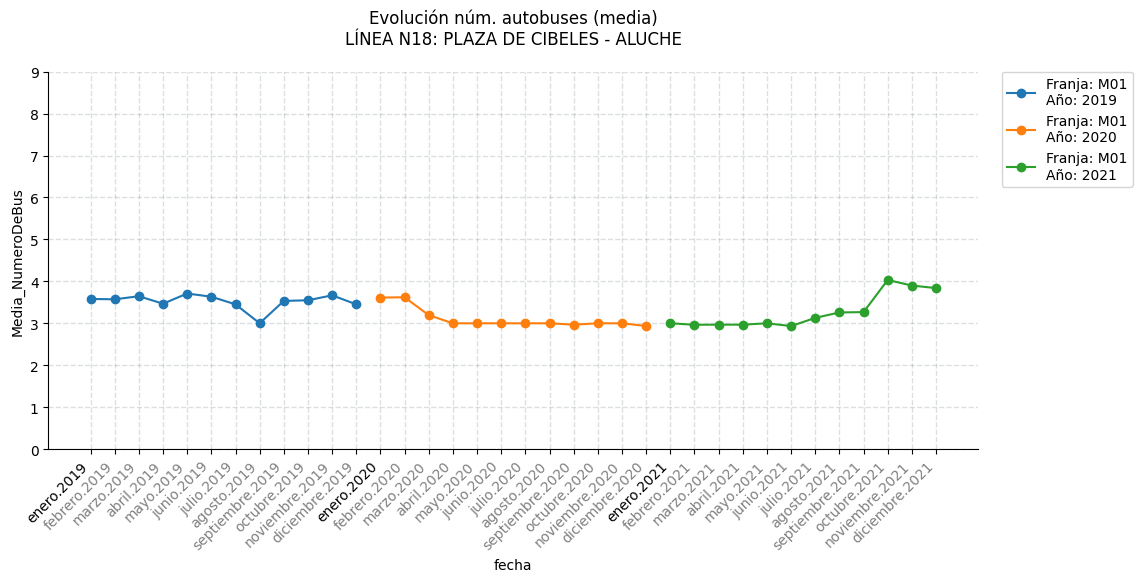

In [ ]:
dff = tmp2.sort_values(by='diff_key1_key3').reset_index(drop=True).loc[0,:]
graficar(num_linea=dff['CLinea'],franja=dff['IDFranja'])

In [ ]:
pd.DataFrame(columns=['Linea','Franja','CochesActual','CochesAnt','FechaActual','FechaAnt'])

,Linea,Franja,CochesActual,CochesAnt,FechaActual,FechaAnt


In [ ]:
pd.DataFrame(columns=['LineaFranja','CochesActual','CochesAnt','FechaActual','FechaAnt'])

,LineaFranja,CochesActual,CochesAnt,FechaActual,FechaAnt
